In [1]:
import pandas as pd

# Load the CSV file
file_path = 'CustomerSegmentationML/Dataset/online_retail_II.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

# Display the column names
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [3]:
# Drop rows with Customer ID
df = df.dropna(subset=['Customer ID'])

# Remove duplicates
df = df.drop_duplicates()

# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Total Amount (Quantity * Price)
df['TotalAmount'] = df['Quantity'] * df['Price']

# Display the cleaned data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [4]:
import datetime as dt

# Define a reference date for recency calculation
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM values
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display RFM data
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,67,15,-51.74
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,4,2646.99
12351.0,11,1,300.93


In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the RFM data
rfm_scaled = scaler.fit_transform(rfm)

# Convert scaled data back to a DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

# Display scaled RFM data
rfm_scaled_df.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,-0.248511,0.956994,-0.228842
12347.0,-0.900473,-0.336439,-0.067374
12348.0,-0.177203,-0.435934,-0.196679
12349.0,-0.492997,-0.137449,0.088061
12351.0,-0.818977,-0.435934,-0.187430


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the model
rfm_scaled_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# Calculate silhouette score
silhouette_avg = silhouette_score(rfm_scaled, rfm_scaled_df['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

# Display clustered data
rfm_scaled_df.head()

Silhouette Score: 0.6153049408322929


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,-0.248511,0.956994,-0.228842,0
12347.0,-0.900473,-0.336439,-0.067374,0
12348.0,-0.177203,-0.435934,-0.196679,0
12349.0,-0.492997,-0.137449,0.088061,0
12351.0,-0.818977,-0.435934,-0.187430,0


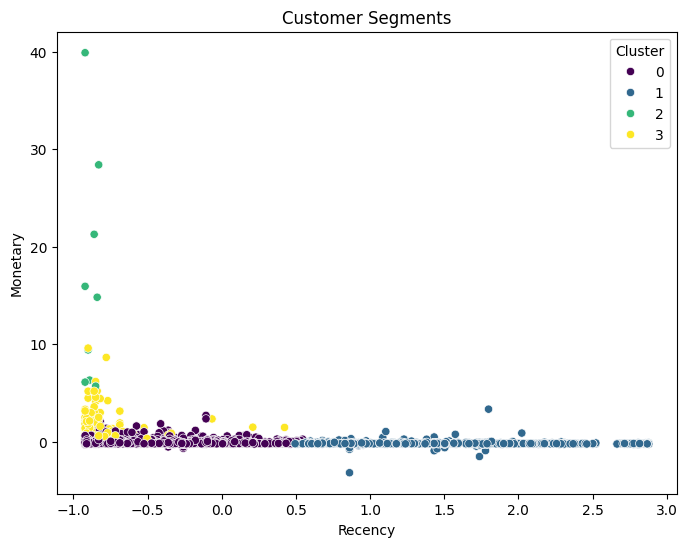

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm_scaled_df, palette='viridis')
plt.title('Customer Segments')
plt.show()

In [8]:
# Save the clustered data to a CSV file for use in Power BI
rfm_scaled_df.to_csv('CustomerSegmentationML/Dataset/rfm_clusters.csv')